# Tutorial for MDC tool

In this notebook, it is presented a brief tutorial on how to define and train a small Convolutional Neural Network for the classification of the MNIST Dataset. At the end of the notebook, it will be showed how to convert the keras model into the QONNX format.

The MNIST database of handwritten digits, available from this page, has a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image (https://yann.lecun.com/exdb/mnist/).

![alt text](images/mnist_eg.png "MNIST example")



Keras (https://keras.io/) is an open source free library that gives access to an interface for Neural Networks (NN) in Python. It is now integrated into the Tensorflow library.
With Keras we have the possibility of defining and training neural networks. QKeras (https://github.com/google/qkeras) is a quantization extension to Keras that provides drop-in replacement for some of the Keras layers, especially the ones that creates parameters and activation layers, and perform arithmetic operations, so that we can quickly create a deep quantized version of Keras network.


In this example we are going to explore the capabilities of Qkeras, by defining and training a Convolutional Neural Network.
First, we import the necessaries packages and do some checks on libraries versions 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
import os

2024-11-14 16:49:24.656470: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-14 16:49:24.924910: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/home/fede/miniconda3/envs/hls4ml-tutorial/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Now we create a folder to store the outputs of this script.

In [4]:
# Specify the folder name
folder_name = 'Mnist_Training'

script_path = os.getcwd()
# Get the current working directory
current_directory = os.path.dirname(script_path)

# Print the current working directory
print("Current working directory:", current_directory)


# Create the full path to the new folder
output_path = current_directory + "/" + folder_name

# Check if the folder already exists
if not os.path.exists(output_path):
    # Create the folder
    os.makedirs(output_path)
    print(f"Folder '{folder_name}' created successfully.")
else:
    print(f"Folder '{folder_name}' already exists.")

print(output_path)

Current working directory: /home/fede/Assegno_UNISS/qonnx2mdc
Folder 'Mnist_Training' already exists.
/home/fede/Assegno_UNISS/qonnx2mdc/Mnist_Training


It is time to load the MNIST dataset, and to extract information like training size (train_size), the input shape (input__shape) and the number of classes to classify (n_classes)

Training on 60000 samples of input shape (28, 28, 1), belonging to 10 classes


2024-11-14 16:49:51.257191: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


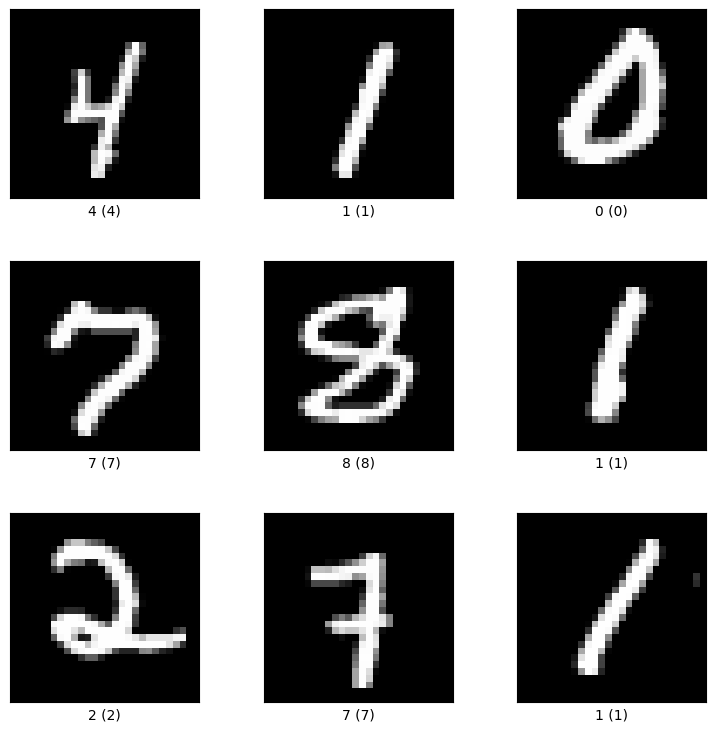

In [5]:
ds_train, info = tfds.load('mnist', split='train[:90%]', with_info=True, as_supervised=True)
ds_test = tfds.load('mnist', split='test', shuffle_files=True, as_supervised=True)
ds_val = tfds.load('mnist', split='train[-10%:]', shuffle_files=True, as_supervised=True)

assert isinstance(ds_train, tf.data.Dataset)
train_size = int(info.splits['train'].num_examples)
input_shape = info.features['image'].shape
n_classes = info.features['label'].num_classes

print('Training on {} samples of input shape {}, belonging to {} classes'.format(train_size, input_shape, n_classes))
fig = tfds.show_examples(ds_train, info)

We define a function to apply some preprocessing to the dataset and we manage the training and validation sets

In [6]:
def preprocess(image, label, nclasses=10):
    image = tf.cast(image, tf.float32) / 255.0
    label = tf.one_hot(tf.squeeze(label), nclasses)
    return image, label

In [7]:
batch_size = 1024

train_data = ds_train.map(preprocess, n_classes)  # Get dataset as image and one-hot encoded labels, divided by max RGB
train_data = train_data.shuffle(4096).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

for example in train_data.take(1):
    break
print("X train batch shape = {}, Y train batch shape = {} ".format(example[0].shape, example[1].shape))

val_data = ds_val.map(preprocess, n_classes)
val_data = val_data.batch(batch_size)
val_data = val_data.prefetch(tf.data.experimental.AUTOTUNE)

# For  testing, we get the full dataset in memory as it's rather small.
# We fetch it as numpy arrays to have access to labels and images separately
X_test, Y_test = tfds.as_numpy(tfds.load('mnist', split='test', batch_size=-1, as_supervised=True))
X_test, Y_test = preprocess(X_test, Y_test, nclasses=n_classes)
print("X test batch shape = {}, Y test batch shape = {} ".format(X_test.shape, Y_test.shape))

X train batch shape = (1024, 28, 28, 1), Y train batch shape = (1024, 10) 
X test batch shape = (10000, 28, 28, 1), Y test batch shape = (10000, 10) 


2024-11-14 16:50:03.982753: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Here, the model is defined. Each layer has its own kernel_quantizers and bias_quantizers, which are functions that apply the quantization to, respectively, weights and biases of the Conv and Gemm layers, and QActivations, which quantizes the activations. While all the Relu layers are quantized, even if with different precisions for each model, we always left untouched the last activation, the Sigmoid layer, to achieve a better accuracy.


In [8]:
from keras.layers import *
from qkeras import *
from qkeras.qlayers import QDense, QActivation, quantized_bits, quantized_relu
from qkeras import QConv2D
from keras.models import Model
from tensorflow.keras.regularizers import l1


x = x_in = Input(shape=input_shape, name = "input_layer")

x = QConv2D(32, (3,3), name = "q_conv2d", padding='same',kernel_quantizer= quantized_bits(bits=8, integer=4, alpha=1),
    bias_quantizer= quantized_bits(bits=8, integer=4, alpha=1))(x)
x = QActivation(quantized_relu(bits=16, integer=8, use_sigmoid=0, negative_slope=0.0), name="act_1")(x)
x = MaxPooling2D(pool_size=(2,2),name = "max_pool_1")(x)
x = QConv2D(32, (3,3), name = "q_conv2d_1",padding='same',kernel_quantizer= quantized_bits(bits=4, integer=2, alpha=1),
    bias_quantizer= quantized_bits(bits=4, integer=2, alpha=1))(x)
x = QActivation(quantized_relu(bits=16, integer=8, use_sigmoid=0, negative_slope=0.0), name="act_2")(x)
x = MaxPooling2D(pool_size=(2,2), name = "max_pool_2")(x)
x = Flatten(name = "flatten")(x)
x = QDense((10),name = "q_dense",kernel_quantizer= quantized_bits(bits=8, integer=4, alpha=1),
    bias_quantizer= quantized_bits(bits=8, integer=4, alpha=1)) (x)   # num_classes = 10
x_out = Activation('sigmoid', name='output_sigmoid')(x)

qmodel = Model(inputs=[x_in], outputs=[x_out], name='qkeras')

qmodel.summary()

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Model: "qkeras"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 28, 28, 1)]       0         
                                                                 
 q_conv2d (QConv2D)          (None, 28, 28, 32)        320       
                                                                 
 act_1 (QActivation)         (None, 28, 28, 32)        0         
                                                                 
 max_pool_1 (MaxPooling2D)   (None, 14, 14, 32)        0         
                                                                 
 q_conv2d_1 (QConv2D)        (None, 14, 14, 32)        9248      
                                                                 
 act_2 (QActivation)         (None, 14, 14, 32)        0         
                                                                 
 max_pool_2 (MaxPooling2D)   (None, 7, 7, 32)          0    

/home/fede/miniconda3/envs/hls4ml-tutorial/lib/python3.10/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer HeNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Here, the training phase can start. A low number of epochs is chosen as the model is fairly small and simple, leading to a low training time. We save both the whole model and separately, its weights.

In [9]:
train = True

n_epochs = 3
if train:
    LOSS = tf.keras.losses.CategoricalCrossentropy()
    OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=3e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=True)
    qmodel.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=["accuracy"])

    callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=10, verbose=1),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    ]

    start = time.time()
    history = qmodel.fit(train_data, epochs=n_epochs, validation_data=val_data, callbacks=callbacks, verbose=1)
    end = time.time()
    print('\n It took {} minutes to train!\n'.format((end - start) / 60.0))

    qmodel.save_weights("model_weights.h5")

    qmodel.save('model_1.h5')

Epoch 1/3
53/53 [==============================] - 11s 199ms/step - loss: 3.1780 - accuracy: 0.6827 - val_loss: 0.5641 - val_accuracy: 0.8795 - lr: 0.0030
Epoch 2/3
53/53 [==============================] - 10s 193ms/step - loss: 0.3722 - accuracy: 0.9083 - val_loss: 0.2860 - val_accuracy: 0.9242 - lr: 0.0030
Epoch 3/3
53/53 [==============================] - 10s 190ms/step - loss: 0.2308 - accuracy: 0.9361 - val_loss: 0.2002 - val_accuracy: 0.9463 - lr: 0.0030

 It took 0.5299594203631083 minutes to train!



At this point, the keras model can be converted into the QONNX format. The QONNX format is an exstension of ONNX, an open format built to represent machine learning models. ONNX defines a common set of operators - the building blocks of machine learning and deep learning models - and a common file format to enable AI developers to use models with a variety of frameworks, tools, runtimes, and compilers (https://onnx.ai/).

QONNX (Quantized ONNX), starting from ONNX, introduces three new custom operators, Quant, BipolarQuant, and Trunc, in order to represent arbitrary-precision uniform quantization in ONNX. This enables representation of binary, ternary, 3-bit, 4-bit, 6-bit or any other quantization (https://github.com/fastmachinelearning/qonnx).

In [10]:
from qonnx.converters import from_keras

path = output_path + '/qonnx_model_1.onnx'
print("conversion to qonnx...")
qonnx_model, _  = from_keras(
    qmodel,
    name="qkeras_to_qonnx_converted",
    input_signature=None,
    opset=None,
    custom_ops=None,
    custom_op_handlers=None,
    custom_rewriter=None,
    inputs_as_nchw=None,
    extra_opset=None,
    shape_override=None,
    target=None,
    large_model=False,
    output_path = path,
)

conversion to qonnx...


2024-11-14 16:50:52.887856: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2024-11-14 16:50:52.887942: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2024-11-14 16:50:52.916299: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2024-11-14 16:50:52.916365: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session


To leverage the capabilities of the MDC tool of merging different CNN models into onereconfigurable accelerator, we take the original model, change the precision of one or more layers, and freeze the others during training while fine-tuning is applied to the changed layers. This enables MDC to reuse the common, unchanged layers. In this example, we changed the precision of the second Convolutional layer ("q_conv2d_1") from 4 to 8 bits.

In [11]:
x = x_in = Input(shape=input_shape, name = "input_layer")

x = QConv2D(32, (3,3), name = "q_conv2d", padding='same',kernel_quantizer= quantized_bits(bits=8, integer=4, alpha=1),
    bias_quantizer= quantized_bits(bits=8, integer=4, alpha=1))(x)
x = QActivation(quantized_relu(bits=16, integer=8, use_sigmoid=0, negative_slope=0.0), name="act_1")(x)
x = MaxPooling2D(pool_size=(2,2),name = "max_pool_1")(x)
x = QConv2D(32, (3,3), name = "q_conv2d_1",padding='same',kernel_quantizer= quantized_bits(bits=8, integer=4, alpha=1),
    bias_quantizer= quantized_bits(bits=4, integer=2, alpha=1))(x)
x = QActivation(quantized_relu(bits=16, integer=8, use_sigmoid=0, negative_slope=0.0), name="act_2")(x)
x = MaxPooling2D(pool_size=(2,2), name = "max_pool_2")(x)
x = Flatten(name = "flatten")(x)
x = QDense((10),name = "q_dense",kernel_quantizer= quantized_bits(bits=8, integer=4, alpha=1),
    bias_quantizer= quantized_bits(bits=8, integer=4, alpha=1)) (x)   # num_classes = 10
x_out = Activation('sigmoid', name='output_sigmoid')(x)

new_qmodel = Model(inputs=[x_in], outputs=[x_out], name='qkeras')

new_qmodel.summary()

Model: "qkeras"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 28, 28, 1)]       0         
                                                                 
 q_conv2d (QConv2D)          (None, 28, 28, 32)        320       
                                                                 
 act_1 (QActivation)         (None, 28, 28, 32)        0         
                                                                 
 max_pool_1 (MaxPooling2D)   (None, 14, 14, 32)        0         
                                                                 
 q_conv2d_1 (QConv2D)        (None, 14, 14, 32)        9248      
                                                                 
 act_2 (QActivation)         (None, 14, 14, 32)        0         
                                                                 
 max_pool_2 (MaxPooling2D)   (None, 7, 7, 32)          0    

Here we load the weights of the original model and freeze every layer, expect the "q_conv2d_1" one. AFter this operation, we can start the training of this new model: only the "q_conv2d_1" will be able to change the value of its weights.

In [12]:
new_qmodel.load_weights("model_weights.h5")

for layer in new_qmodel.layers:
    if layer.name != "q_conv2d_1":
        layer.trainable = False

In [13]:
train = True

n_epochs = 3
if train:
    LOSS = tf.keras.losses.CategoricalCrossentropy()
    OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=3e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=True)
    new_qmodel.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=["accuracy"])

    callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=10, verbose=1),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    ]

    start = time.time()
    history = new_qmodel.fit(train_data, epochs=n_epochs, validation_data=val_data, callbacks=callbacks, verbose=1)
    end = time.time()
    print('\n It took {} minutes to train!\n'.format((end - start) / 60.0))


    new_qmodel.save('model_2.h5')

Epoch 1/3
53/53 [==============================] - 9s 163ms/step - loss: 0.1829 - accuracy: 0.9465 - val_loss: 0.1730 - val_accuracy: 0.9525 - lr: 0.0030
Epoch 2/3
53/53 [==============================] - 8s 159ms/step - loss: 0.1458 - accuracy: 0.9568 - val_loss: 0.1568 - val_accuracy: 0.9553 - lr: 0.0030
Epoch 3/3
53/53 [==============================] - 8s 159ms/step - loss: 0.1329 - accuracy: 0.9610 - val_loss: 0.1552 - val_accuracy: 0.9567 - lr: 0.0030

 It took 0.4333810726801554 minutes to train!



We can double check if effecively the new model's weights are changed. After this chechk, we can convert also this new model into the QONNX format.

In [14]:
# Lists to store the names of layers with matching and non-matching weights
matching_layers = []
non_matching_layers = []

for original_layer, modified_layer in zip(qmodel.layers, new_qmodel.layers):
    

    # Check if the layer has weights (some layers like Dropout do not)
    if original_layer.get_weights() and modified_layer.get_weights():
        # Compare weights
        weights_match = all(
            (original_weight == modified_weight).all()
            for original_weight, modified_weight in zip(original_layer.get_weights(), modified_layer.get_weights())
        )
        
        if weights_match:
            matching_layers.append(original_layer.name)
        else:
            non_matching_layers.append(original_layer.name)

print("Layers with matching weights:", matching_layers)
print("Layers with non-matching weights:", non_matching_layers)


Layers with matching weights: ['q_conv2d', 'q_dense']
Layers with non-matching weights: ['q_conv2d_1']


In [15]:
from qonnx.converters import from_keras

path = output_path + '/qonnx_model_2.onnx'
print("conversion to qonnx...")
qonnx_model, _  = from_keras(
    qmodel,
    name="qkeras_to_qonnx_converted",
    input_signature=None,
    opset=None,
    custom_ops=None,
    custom_op_handlers=None,
    custom_rewriter=None,
    inputs_as_nchw=None,
    extra_opset=None,
    shape_override=None,
    target=None,
    large_model=False,
    output_path = path,
)

conversion to qonnx...


2024-11-14 16:51:42.476193: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2024-11-14 16:51:42.476269: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2024-11-14 16:51:42.493923: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2024-11-14 16:51:42.493989: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
